In [69]:
import numpy as np
import networkx as nx
import pandas
import matplotlib.pyplot as plt
import itertools
import scipy
import tqdm

## Load data

In [71]:
dataset = "example"
datadir = "example/"
df = pandas.read_csv(datadir + dataset+".csv")
df[:5]

,parent1,child1,parent2,child2,parent3,child3
0,3,3,2,3,1,3
1,1,3,2,3,2,3
2,3,1,1,2,3,1
3,1,3,1,2,3,2
4,2,3,3,2,2,1


In [72]:
column_names = list(df.columns)
data = np.array(df)
node_info = [(column_names[i], (np.min(data[:,i]), np.max(data[:,i]))) for i in range(data.shape[1])]
print(node_info)

[('parent1', (1, 3)), ('child1', (1, 3)), ('parent2', (1, 3)), ('child2', (1, 3)), ('parent3', (1, 3)), ('child3', (1, 3))]


## BayesNet Datastructure

In [54]:
class BayesNet:
    
    def __init__(self, adjacency_matrix, node_info):
        self.adjacency_matrix = adjacency_matrix
        self.G = nx.convert_matrix.from_numpy_array(self.adjacency_matrix, create_using=nx.DiGraph())
        
        if self.is_dag:
            self.node_info = node_info
            self.node_names = [info[0] for info in self.node_info]
            self.n_nodes = len(self.node_info)

            self.vals_per_node = [vals[1] for name, vals in node_info]
            self.node_values = [np.arange(vals[0], vals[1] + 1) for name, vals in node_info]
            self.parent_sets = [list(self.G.predecessors(i)) for i in self.G.nodes]

            n_parental_instances = [np.prod([self.vals_per_node[p] for p in parents]) for parents in self.parent_sets]
            m_matrices = [np.zeros((int(npis), int(vals))) for npis, vals in zip(n_parental_instances, self.vals_per_node)]

            self.ms = m_matrices
    
    def count_ms(self, data):
        for i in range(self.n_nodes):
            parents = self.parent_sets[i]
            n_parents = len(parents)
            if n_parents > 0:
                parental_instantiations = itertools.product(*[self.node_values[p] for p in parents])
                for j, pi in enumerate(parental_instantiations):
                    mask = data[:,parents[0]] == pi[0]
                    for k in range(1,n_parents):
                        mask = np.logical_and(mask, data[:,k] == pi[k])
                    pi_data = data[mask,i]
                    vals, counts = np.unique(pi_data, return_counts=True)
                    self.update_counts(i, j, vals, counts)
            else:
                vals, counts = np.unique(data[:,i], return_counts=True)
                self.update_counts(i, 0, vals, counts)
    
    def update_counts(self, node, pi, vals, counts):
        for v, c in zip(vals, counts):
            self.ms[node][pi, v - 1] += c
    
    @property
    def is_dag(self):
        return nx.is_directed_acyclic_graph(self.G)
    
    def draw(self):
        nx.draw(self.G, labels={i:info[0] for i, info in enumerate(self.node_info)})
        
    def save(self, filename):
        with open(filename, 'w') as f:
            for edge in self.G.edges():
                f.write("{}, {}\n".format(self.node_names[edge[0]], self.node_names[edge[1]]))
        

In [55]:
def get_dag(p):
    no_dag = True
    while no_dag:    
        A = np.random.binomial(1, p, size=[len(node_info)] * 2)
        np.fill_diagonal(A, 0)
        g = BayesNet(A, node_info)
        no_dag = not g.is_dag
    return g



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]

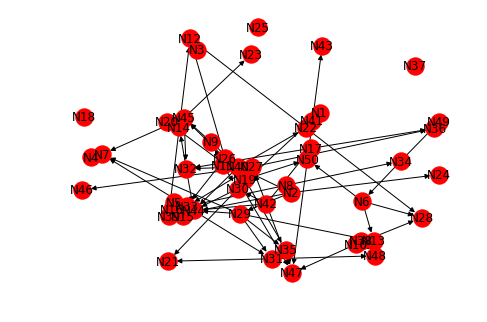

In [60]:
n_dags = 2
p = 0.04
dags = [get_dag(p) for _ in tqdm.tqdm(range(n_dags))]
g = dags[0]
g.draw()

In [76]:
A = np.zeros((6,6))
A[0,1] = 1
A[2,3] = 1
A[4,5] = 1
g = BayesNet(A, node_info)

In [61]:
for g in dags:
    g.count_ms(data)

## Compute Bayesian Score

In [74]:
def bay_score_node(m):
    p = np.sum(scipy.special.loggamma(m + 1))
    p += m.shape[0] * scipy.special.loggamma(m.shape[1])
    p -= np.sum(scipy.special.loggamma(m.shape[1] + np.sum(m, axis=1)))
    return p
    
def compute_bayesian_score(ms):
    return np.sum([bay_score_node(m) for m in ms])

In [75]:
scores = [compute_bayesian_score(g.ms) for g in dags]

In [64]:
gmin = dags[np.argmin(scores)]
gmax = dags[np.argmax(scores)]

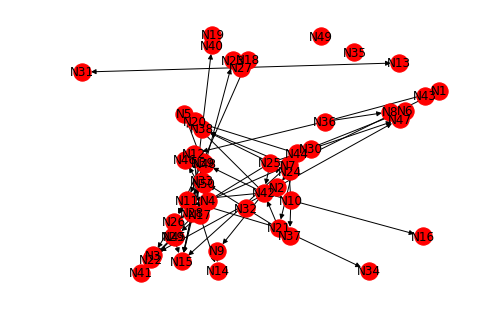

In [65]:
gmin.draw()

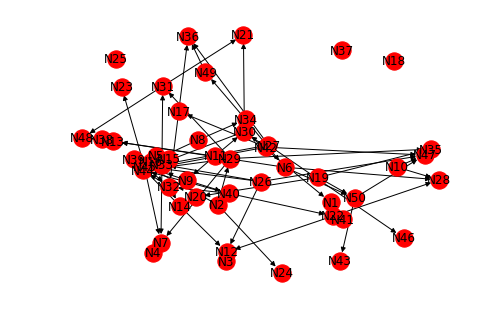

In [66]:
gmax.draw()

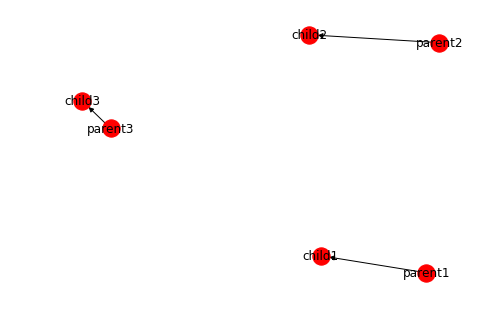

In [80]:
compute_bayesian_score(g.ms)
g.draw()

## Store results

In [67]:
outdir = "test_outputs/"
gmax.save(outdir + dataset + ".gph")

In [68]:
print(scores)

[-499952.68454392103, -502564.53733780317]


In [ ]:
G = nx.DiGraph()
G.add_edge(1,2)
G.add_edge(3,4)
G.add_edge(4,1)
nx.draw(G, labels={i+1:str(i + 1) for i in range(4)})

In [46]:
A = nx.to_numpy_array(G)

In [68]:
parents = [G.predecessors(node) for node in G.nodes]


[4]

In [42]:
X = np.zeros((3,3))
X[1,0] = 1
X[1,1] = 1
X[1,2] = 1
X[0,0] = 1
X[0,1] = 1

In [44]:
mask = np.logical_and(X[:,0] == 1, X[:,1] == 1)
X[mask,-1]

array([0., 1.])

In [38]:
A[mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 3

In [49]:
for j in itertools.product((), ()):
    print("hi")

In [51]:
a = np.array([1,1,2,3,4,6,7,3,3])
np.unique(a, return_counts=True)

(array([1, 2, 3, 4, 6, 7]), array([2, 1, 3, 1, 1, 1], dtype=int64))